### Imports + tooling

In [1]:
import pandas as pd
import seaborn as sns
import scipy as sp
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors

# figure size in inches
rcParams['figure.figsize'] = 12,8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def load_data(path):
    metadata = []
    with open(path) as f:
        header = 0
        while True:
            line = next(f)
            if line.startswith("#"):
                metadata.append(line)
                header += 1
            else:
                break
                
    column_name_map = {k: v for k, v in re.findall("COLUMN\s+(\w+):\s+([^,]+)", "".join(metadata))}
    df = pd.read_csv(path, skiprows=header, low_memory=False)
    df = df.rename(columns=column_name_map)

    return df

### Load data

In [2]:
df = load_data("./data/planetary_systems_composite.csv")
len(df.index)

5241

In [5]:
df.to_csv("./data/planetary_data.csv")

### Theoretical predicted decay (ignoring effect due to eccentricity)

We assume a simple tidal decay caused only by tides induced on the star by the planet. This simplification means our differential equation is more easily modellable. In future I should work out how to fit a model to the full set of differential equations.

In [8]:
earth_radius = 6.378e6  # m
earth_mass = 5.972e24  # kg
solar_radius = 6.957e8 # m
solar_mass = 1.989e30  # kg

a = df['Orbit Semi-Major Axis [au]'] * sp.constants.au
Rs = df['Stellar Radius [Solar Radius]'] * solar_radius
Rp = df['Planet Radius [Earth Radius]'] * earth_radius
Mp = df['Planet Mass or Mass*sin(i) [Earth Mass]'] * earth_mass
Ms = df['Stellar Mass [Solar mass]'] * solar_mass

a_l = ((df['Orbit Semi-Major Axis [au]'] + df['Orbit Semi-Major Axis Lower Unc. [au]']) * sp.constants.au).fillna(a)
Rs_l = ((df['Stellar Radius [Solar Radius]'] + df['Stellar Radius Lower Unc. [Solar Radius]']) * solar_radius).fillna(Rs)
Rp_l = ((df['Planet Radius [Earth Radius]'] + df['Planet Radius Lower Unc. [Earth Radius]']) * earth_radius).fillna(Rs)
Mp_l = ((df['Planet Mass or Mass*sin(i) [Earth Mass]'] + df['Planet Mass or Mass*sin(i) [Earth Mass] Lower Unc.']) * earth_mass).fillna(Mp)
Ms_l = ((df['Stellar Mass [Solar mass]'] + df['Stellar Mass Lower Unc. [Solar mass]']) * solar_mass).fillna(Ms)

a_u = ((df['Orbit Semi-Major Axis [au]'] + df['Orbit Semi-Major Axis Upper Unc. [au]']) * sp.constants.au).fillna(a)
Rs_u = ((df['Stellar Radius [Solar Radius]'] + df['Stellar Radius Upper Unc. [Solar Radius]']) * solar_radius).fillna(Rs)
Rp_u = ((df['Planet Radius [Earth Radius]'] + df['Planet Radius Upper Unc. [Earth Radius]']) * earth_radius).fillna(Rs)
Mp_u = ((df['Planet Mass or Mass*sin(i) [Earth Mass]'] + df['Planet Mass or Mass*sin(i) [Earth Mass] Upper Unc.']) * earth_mass).fillna(Mp)
Ms_u = ((df['Stellar Mass [Solar mass]'] + df['Stellar Mass Upper Unc. [Solar mass]']) * solar_mass).fillna(Ms)

Qs = 10 ** 5.5

neg_da_dt = 9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (a ** -5.5)
neg_da_dt_lower_bound = 9/2 * ((sp.constants.G / Ms_u) ** 0.5) * ((Rs_l ** 5 * Mp_l) / Qs) * (a_u ** -5.5)
neg_da_dt_upper_bound = 9/2 * ((sp.constants.G / Ms_l) ** 0.5) * ((Rs_u ** 5 * Mp_u) / Qs) * (a_l ** -5.5)
lower_bound_error = neg_da_dt - neg_da_dt_lower_bound
upper_bound_error = neg_da_dt_upper_bound - neg_da_dt
neg_da_dt = neg_da_dt.rename("-da/dt [m/s]")

df["-da/dt [m/s]"] = neg_da_dt
df["-dP/dt [s/s]"] = 3 * sp.constants.pi * np.sqrt((df["Orbit Semi-Major Axis [au]"] * sp.constants.au) / (sp.constants.G * df["Stellar Mass [Solar mass]"] * solar_mass)) * df["-da/dt [m/s]"]
df["-dP/dE [s/epoch]"] = df["-dP/dt [s/s]"] * df["Orbital Period [days]"] * 24 * 60 * 60
df["-dP/dE [ms/epoch]"] = df["-dP/dE [s/epoch]"] * 1000
df["-dP/dE error [ms/epoch]"] = 0.5 * (neg_da_dt_upper_bound - lower_bound_error) *  3 * sp.constants.pi * np.sqrt((df["Orbit Semi-Major Axis [au]"] * sp.constants.au) / (sp.constants.G * df["Stellar Mass [Solar mass]"] * solar_mass))  * df["Orbital Period [days]"] * 24 * 60 * 60 * 1000

df["TTV after 10 years [s]"] = 0.5 * df["-dP/dE [s/epoch]"] * ((10 * 365 / df["Orbital Period [days]"]) ** 2)

In [9]:
print(f"Out of {len(neg_da_dt.index)} planets we have data to compute an estimated decay for {neg_da_dt.notna().sum()}")

Out of 5241 planets we have data to compute an estimated decay for 4760


Text(0.5, 0, 'Predicted TTV after 10 years [s]')

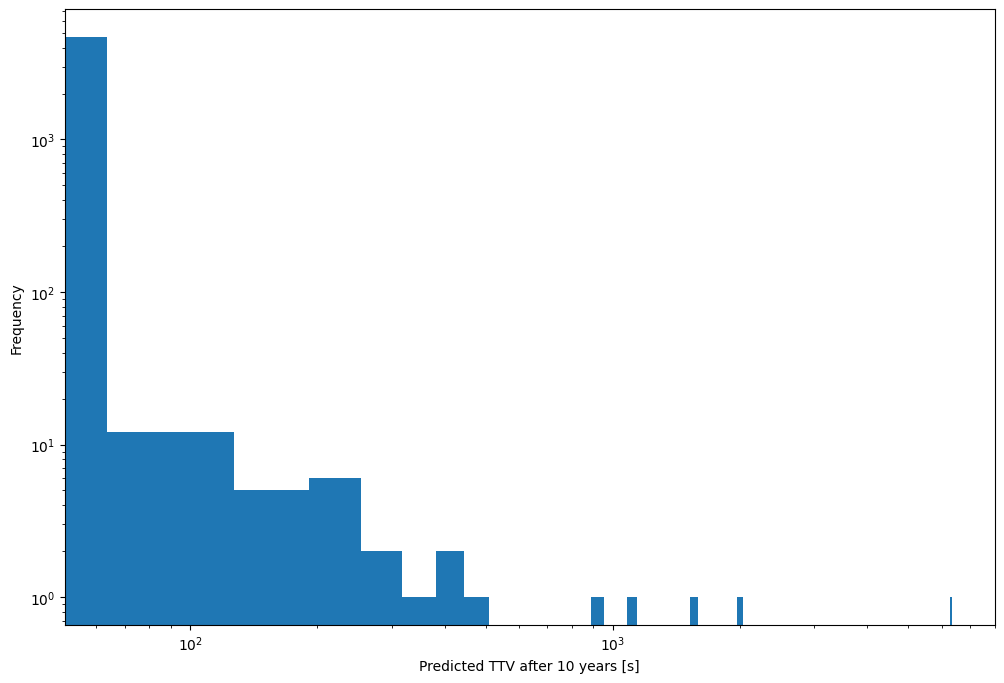

In [10]:
ax = df["TTV after 10 years [s]"].plot.hist(bins=100, logy=True, logx=True)
ax.set_xlabel("Predicted TTV after 10 years [s]")

In [11]:
df[["Planet Name", "TTV after 10 years [s]"]].sort_values(by="TTV after 10 years [s]", ascending=False).head(15)

,Planet Name,TTV after 10 years [s]
4855,TOI-2109 b,6355.366553
1746,KELT-1 b,1974.679104
5071,WASP-18 b,1587.607305
1435,K2-22 b,1090.465686
4181,Kepler-718 b,928.791883
1752,KELT-16 b,490.040308
5001,WASP-103 b,424.754630
1688,K2-52 b,423.064111
4716,OGLE-TR-56 b,325.974719
1311,K2-137 b,302.819737


In [12]:
df.to_csv("./results/3_theoretical_decay.csv")

### Constructing an observability metric

#### What do we mean by an observability metric?

Ranking planets by theorised decay is great, but doesn't account for any difficulties we might have in observing these transits. Instead I'm going to define an observability metric: the time required to confirm or reject orbital decay to a given statistical signficance level.

We will combine our predicted decay with some knowledge of the measurement uncertainties to estimate the most promising candidates to evaluate over a 10 year period.

#### What should an observability significance metric encode?

The observability metric we come up with should satisy five key properties. A candidate planet should be ranked as more "observable" if for this planet:

1. The equations of motion of tidal decay predict a larger decay rate.
2. Transit times are measured with less uncertainty.
3. There is a greater range of time between the first and last observations.
4. More transits are recorded.

We must also take care to ensure the uncertainty in the reference time is correctly accounted for. Existing literature often fails to account for the fact that $T_{0}$ is also a random variable and theresfore should be fitted too. If not, you risk biasing the model with an arbitrary prior.

#### Idea: a joint Bayesian posterior model:

One issue with the current methods in the literature is they fit separate models rather than a joint model. Comparisons must then be made based on the distribution of residuals (e.g. chi-squared or BIC) - this metric is dimensionless and hard to interpret. Worse still, each model has a different number of degrees of freedom, so their residuals aren't directly comparable.

My assertion is that what we really care about isn't which model has smaller residuals under the data, but rather - what is the posterior distribution over all the parameters that might determine the dynamics of the system? i.e. given a full set of parameters that together describe all the possible ways the system can behave, what is a posteriori estimate for each of these variables. The mean and variance of these distributions will encode how "well" a particular physical phenomena e.g. decay, precession etc. fits the given situation.

For example, if precession is very apparently occuring but not decay, we should see a large absolute mean and small variance on precession parameters, but small mean on decay parameters.

I propose a new modelling approach where we jointly fit the models we want to investigate. In the process we identify any parameters that should be the same under either model, like T0 and P0. It doesn't make physical sense that different models should fit the same parameters with different values. You know that there is a single reference transit time and that reference time should be the same regardless of the model so it shouldn't be allowed to vary.

We can construct a single model which reflects all possible configurations of the dynamics of the planetary system and fit once to all the necessary parameters. If these different scenarios are for whatever reason "physically incompatible" e.g. maybe you can't have apsidal precession AND orbital decay at the same time, then you simply enforce that in your prior on the parameters.

So how do we do we this? To start with, let's set up as a simple Bayesian model for orbital decay (no pression or other dynamics) assuming only two transits are observed at a time $\Delta T$ apart. Measurement errors are assumed to be normally distributed and IID.

#### Measurements:

Each individual transit time is a random variable with mean $T$ (a function of epoch E given by the hypothesised model) and a known measurement error $\sigma^{2}$:

$\hat{T}(E) \sim N(T(E), \sigma^{2})$. 

Differences between transit times are therefore also normally distributed but with twice the variance:

$\Delta \hat{T}(E_{1},E_{2}) = \hat{T}(E_{2})-\hat{T}(E_{1}) \sim N(T(E_{2})-T(E_{1}), 2\sigma^{2})$

A single transit timing variation between two models (denoted 1 and 2) is therefore distributed as follows:

$\hat{TTV}(E_{1},E_{2}) = \Delta \hat{T}_{2} - \Delta \hat{T}_{1} \sim N((T_{2}(E_{2})-T_{2}(E_{1}))-(T_{1}(E_{2})-T_{1}(E_{1})), 4\sigma^{2})$

The transit time variation is what we "measure".

#### Model:

Now let us makes this concrete by constructing the two models $T_{1}$ and $T_{2}$ that we wish to compare:

$\frac{dt}{dE} = P \implies T(E) = T_{0} + \int_{0}^{E}P(E')dE'$

##### Model 1: constant period

$P(E) = P_{0} \implies T_{1}(E) = T_{0} + P_{0}E$

##### Model 2: constant period decay per orbit

$P(E) = P_{0} + \frac{dP}{dE}E \implies T_{2}(E) = T_{0} + P_{0}E + \frac{1}{2}\frac{dP}{dE}E^2$

#### Likelihood:

Substituting these models into our hypothesised TTV distribution and taking $E_{1} = 0$ and $E_{2} = E$:

$T_{1}(E_{1}) = T_{1}(0) = T_{0}$

$T_{1}(E_{2}) = T_{1}(E) = T_{0} + P_{0}E$

$T_{2}(E_{1}) = T_{2}(0) = T_{0}$

$T_{2}(E_{2}) = T_{2}(E) = T_{0} + P_{0}E + \frac{1}{2}\frac{dP}{dE}E^2$

Enforcing that the reference time and constant period parameters are equal in both models:

$\hat{TTV}(E_{1},E_{2}) = \hat{TTV}(0,E) \sim N(\frac{1}{2}\frac{dP}{dE}E^2, 4\sigma^{2})$

The resulting likelihood of the TTV observations given the decay rate is:

$P(TTV|\frac{dP}{dE}) \sim N(\frac{1}{2}\frac{dP}{dE}E^2, 4\sigma^{2})$

For a close-in massive hot Jupiter the likelihood could look something like:

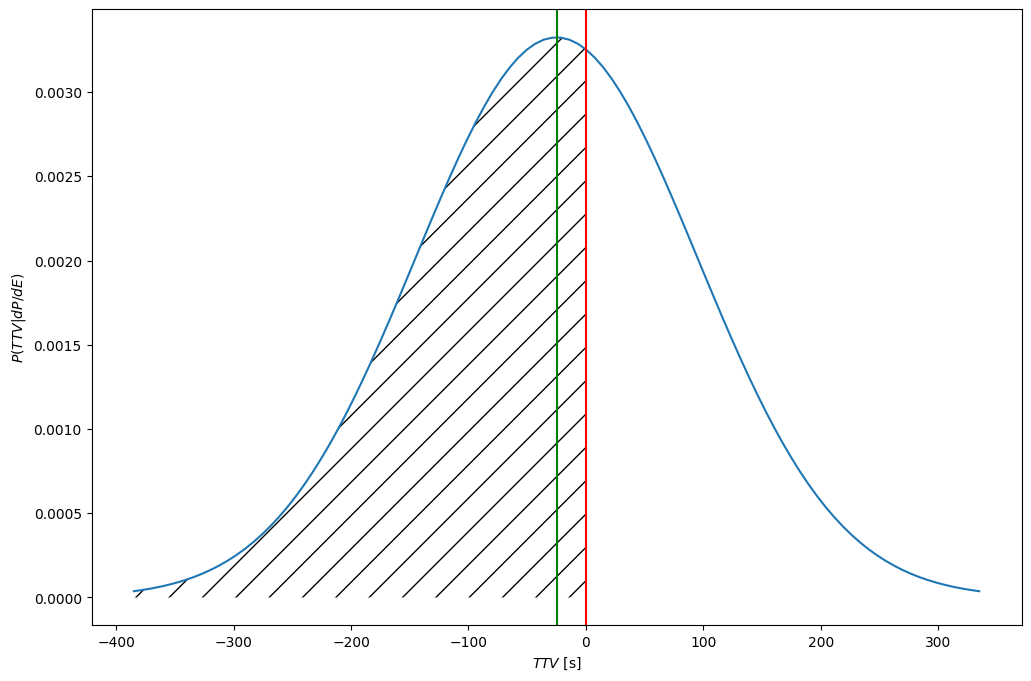

In [22]:
mu = 0.5 * -0.05e-3 * (1000**2)  # predicted decay after 1000 orbits 
variance = 4 * (60**2)  # 1 standard deviation uncertainty ~ 60s
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, sp.stats.norm.pdf(x, mu, sigma))
x_fill = np.linspace(mu - 3*sigma, 0, 100)
plt.fill_between(x_fill, sp.stats.norm.pdf(x_fill, mu, sigma), hatch="/", alpha=0)
plt.axvline(mu, c="green")
plt.axvline(0, c="red")
plt.xlabel("$TTV$ [s]")
plt.ylabel("$P(TTV|dP/dE)$")
plt.show()

#### Prior:

We have no reason to assume anything about the decay rate so let's take a normal prior with arbitrarily large variance to make an effectively "flat" prior. Using a normal prior makes our calculations simpler.

$P(\frac{dP}{dE}) \sim N(\mu_{0}, \sigma_{0}) = N(0, \infty)$

#### Posterior:

We can find the posterior by multiplying the prior by the likelihood and completing the square in the exponent. The resulting distribution is:

$P(\frac{dP}{dE}|TTV) \sim N(\frac{2TTV}{E^2}, \frac{4\sigma^2}{E^4})$

Our estimate of the orbital decay rate is simply the rate we infer from the TTV measurement, with some variance that decreases with the number of epochs over which we measure.


#### Metric:

We can construct an observability metric out of this by constraining the CDF of the posterior distribution to some significance level. For example. to be 97.5% confident that we have observed decay, we want:

$P(\frac{dP}{dE}|TTV \lt 0) = \frac{1}{2}[1+\mathrm{erf}(\frac{-\hat{\frac{dP}{dE}} E^2}{\sqrt{8}\sigma})] = 0.975$

We can invert this equation to find $E$, the number of orbits required before we should be able to observe orbital decay given a theorised $\frac{dP}{dE}$ and known 1 standard-deviation measurement uncertainties $\sigma$:

$E = \sqrt{-{\hat{\frac{dE}{dP}}} * \sqrt{8}\sigma * \mathrm{erf}^{-1}(0.95)}$

Converting into a time-range of constant period observations we obtain the time range required to observe statistically significant orbital decay using only two transit measurements:

$\Delta T = P_{0}E = P_{0} \sqrt{-{\hat{\frac{dE}{dP}}} * \sqrt{8}\sigma * \mathrm{erf}^{-1}(0.95)}$

For Wasp-12b this works out to:

In [23]:
P0 = 1.091420 * 24 * 60 * 60
dp_de = -0.053703e-3
sigma = 60  # assumed

delta_T = P0 * math.sqrt(-(1/dp_de) * math.sqrt(8) * sigma * sp.special.erfinv(0.95))
delta_T / (60 * 60 * 24 * 365)

6.257695669686456

6.3 years for 97.5% significance - this seems reasonable given existing research has confirmed the decay with around 10 years worth of data.

### Ranking all planets by observability of orbital decay

Now let's use this metric to create a new ranking of which planets should be most observable, assuming a 60s 1-sigma uncertainty in transit times.

In [24]:
P0 = df["Orbital Period [days]"] * 24 * 60 * 60
dp_de = -df["-dP/dE [s/epoch]"]
sigma = 60

df["Required Delta T [years]"] = P0 * np.sqrt(-(1/dp_de) * math.sqrt(8) * sigma * sp.special.erfinv(0.95))  / (60 * 60 * 24 * 365)
df[["Planet Name", "Required Delta T [years]"]].sort_values(by="Required Delta T [years]", ascending=True).head(15)

,Planet Name,Required Delta T [years]
4855,TOI-2109 b,1.360283
1746,KELT-1 b,2.440346
5071,WASP-18 b,2.721624
1435,K2-22 b,3.283928
4181,Kepler-718 b,3.558283
1752,KELT-16 b,4.898733
5001,WASP-103 b,5.261755
1688,K2-52 b,5.272257
4716,OGLE-TR-56 b,6.006310
1311,K2-137 b,6.231715


Instead of assuming 60s transit time uncertainties, use the transit midpoint uncertainty specified in the Exoplanet Archive:

In [25]:
P0 = df["Orbital Period [days]"] * 24 * 60 * 60
dp_de = -df["-dP/dE [s/epoch]"]
sigma = 0.5 * (df["Transit Midpoint Upper Unc. [days]"] - df["Transit Midpoint Lower Unc. [days]"]) * 24 * 60 * 60

df["Required Delta T [years]"] = P0 * np.sqrt(-(1/dp_de) * math.sqrt(8) * sigma * sp.special.erfinv(0.95))  / (60 * 60 * 24 * 365)
df[["Planet Name", "Required Delta T [years]"]].sort_values(by="Required Delta T [years]", ascending=True).head(15)

,Planet Name,Required Delta T [years]
4855,TOI-2109 b,0.396494
4181,Kepler-718 b,1.028338
371,HAT-P-7 b,1.287505
5071,WASP-18 b,1.423594
5014,WASP-12 b,1.549701
1831,KOI-13 b,1.861488
1435,K2-22 b,2.280853
4233,Kepler-76 b,2.373871
1752,KELT-16 b,2.562370
384,HATS-18 b,3.279254


### Accounting for multiple transit observations

Of course we can observe more than two transits. To account for the possibility of multiple transits we can think of each subsequent measurement as another transit time variation such that we now measure N transit timing variations of the form:

$\hat{TTV}_{i} = \hat{TTV}(0, E_{i}) \sim N(\frac{1}{2}\frac{dP}{dE}E_{i}^2, 4\sigma^{2})$

Since each transit timing variation's error is IID, the joint probability of a sequence of TTVs can be described by a multivariate normal distribution with no cross correlations:

$P(\{TTV_{i}\}_{i=1}^{i=N}|\frac{dP}{dE}) \sim \mathcal {N}(\frac{1}{2}\frac{dP}{dE}\{E_{i}^2\}_{i=1}^{i=N}, 4\sigma^{2}\boldsymbol{I}) = \prod_{i=1}^{i=N-1} N(\frac{1}{2}\frac{dP}{dE}E_{i}^2, 4\sigma^{2})$

To construct the posterior model we again multiply by the infinite variance prior on dP/dE and complete the square. Now we get that:

$P(\frac{dP}{dE}|TTV) \sim N(\frac{\sum_{i=1}^{i=N-1}E_{i}^4\frac{2TTV_{i}}{E_{i}^2}}{\sum_{i=1}^{i=N-1}{E_{i}^4}}, \frac{4\sigma^2}{\sum_{i=1}^{i=N-1}E_{i}^4})$


Contrasting this with the previous model:
    
$P(\frac{dP}{dE}|TTV) \sim N(\frac{2TTV}{E^2}, \frac{4\sigma^2}{E^4})$


We see that it is similar to before, but now the MAP estimate of dP/dE becomes the average of TTV-derived measurements weighted by how far out they are (i.e. we place more weight on TTVs observed over longer time ranges). Similarly, the variance now scales with both the time range and with the number of measurements.

Note that this result lines up with the standard conjugate prior for IID normal random variables (see https://en.wikipedia.org/wiki/Conjugate_prior), with the only change being the weighting by E^4.

We could swap in our theorised TTVs and invert this equation (with a few assumptions) to get the required number of transits that we need to measure to observe statistically significant decay to some confidence level as before, but I posit that this will only amount to a very small correction on our original estimate as the time range $E^4$ dominates the size of the variance as the number of transits measured increases, not the number of transits themselves.

Let's try it anyway, approximating the sum:


$P(\frac{dP}{dE}|\{TTV_{i}\}_{i=1}^{i=N} \lt 0) = \frac{1}{2}[1+\mathrm{erf}(\frac{-\hat{\frac{dP}{dE}}*N^{\frac{5}{2}}}{2\sqrt{10}\sigma})] = 0.975$

Note that the argument to the ERF increases with more than the square of the number of observations. As a result, the probability of observing statistically significant orbital decay increases with number of observations by a a factor of $\sqrt(N)$ more quickly than in the two transit case.

$E \approx (- {\frac{dE}{dP}} * 2\sqrt{10}\sigma * \mathrm{erf}^{-1}(0.95))^{\frac{2}{5}}$

Compared to the previous metric we need fewer orbits than we previously thought (power of 2/5 rather than 1/2).

Converting into a time-range of constant period observations we obtain the time range required to observe statistically significant orbital decay using consecutive transit measurements:

$\Delta T = P_{0}E = P_{0} * (-{\frac{dE}{dP}} * 2\sqrt{10}\sigma * \mathrm{erf}^{-1}(0.95))^{\frac{2}{5}}$

For Wasp-12b this works out to:

In [26]:
P0 = 1.091420 * 24 * 60 * 60
dp_de = -0.053703e-3
sigma = 60  # assumed

delta_T = P0 * np.power(-(1/dp_de) * 2 * math.sqrt(10) * sigma * sp.special.erfinv(0.95), 0.4)
delta_T / (60 * 60 * 24 * 365)

1.8709636943178622

### Mock up test

* Generate artificial transit time data for a constant period model and a constant decay model, over both a single short time range and two clusters of transit times spread out, and fit to this data.

* We may want to construct a new model that does not assume a known P0.

### Modelling

Next step: use this approach for actual modelling and determining parameter posteriors.

Reached out to Billy Edwards, Simone Hagey and Filip Walter for data.

### Questions

I keep seeing O-C, that's just the same thing as transit timimg deviation right? What does it stand for?

### Further work

* Use ExoClock/ETD/Kepler/Tess to combine fitted values for as many transit times as we can and apply the observability metric to see which planets should currently exhibit observable orbital decay.
* Apsidal precession may be easily conflated with decay. We should model this too and incorporate it into our metric i.e. try to capture the length of time extra we need to differentiate between orbital decay and precession.
* We should try to more accurately model the equations of motion of tidal decay, including:
    * A more accurate $P^{10/3}\frac{dP}{dE}$ term as discussed.
    * Effects of eccentricity on theorised dP/dE.
    * The effect of the coupled differential over time - we can't strictly speaking fit $P^{10/3}\frac{dP}{dE}$ as constant because a is actually changing over time.
* We can also imagine other setups where, given a set of transit time data, we compute whether or not a single individual model can fit the data to within a 97.5% confidence level in the style of accepting or rejecting a null hypothesis. Uncertain about this: or similarly to this approach, inverting the formula to find the time range between two transits that would be required for the 97.5% level measurement to fall outside of the measurement uncertainty of the data.
* Model transit times using these new methods.
* Using better values of Q* for theorised dP/dE.
* Use MCMC posterior methods to include priors in our model and come up with posterior distributions over fitted parameters.
* Fit Q* directly in the model.
* Fit the model directly from the raw lightcurves.
* Add in radial velocity observations into the model.
* Account for line-of-sight accelration and stellar activity in the modelling.